# Clasificador de audio por idioma (español / inglés / francés) con TensorFlow y TensorFlow.js

Este notebook entrena un modelo de audio sencillo que clasifica entre 3 idiomas:
- español
- inglés
- francés

Luego convierte el modelo a TensorFlow.js, aplica unos parches al `model.json` y deja todo listo
para integrarlo en una página web (HTML/JS) que use micrófono y/o archivos de audio.


In [2]:
!pip install -U datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 12.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [3]:
!pip install -q tensorflowjs scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 1.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.38.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
xarray 2025.11.0 requires packaging>=24.1, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.4 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [4]:
# ============================================================
# 1. Instalación y configuración
# ============================================================

# TensorFlow.js para convertir el modelo a TF.js
# datasets para descargar Common Voice desde HuggingFace

import os
from pathlib import Path

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflowjs as tfjs

import kagglehub          # 👈 para descargar datasets de Kaggle
import soundfile as sf     # 👈 para leer .flac

from datasets import load_dataset
from scipy import signal  # para re-muestrear audio

# ============================================================
# 1. Instalación y configuración
# ============================================================

print("Versión de TensorFlow:", tf.__version__)
print("Versión de TensorFlow.js:", tfjs.__version__)

tf.random.set_seed(42)
np.random.seed(42)

AUTOTUNE = tf.data.AUTOTUNE

# Configuración de audio
SAMPLE_RATE = 16000   # 16 kHz
DURATION = 5.0        # segundos que usaremos de cada audio
NUM_SAMPLES = int(SAMPLE_RATE * DURATION)

print("Muestreo objetivo:", SAMPLE_RATE, "Hz")
print("Duración objetivo:", DURATION, "s")
print("Muestras por ejemplo:", NUM_SAMPLES)



Versión de TensorFlow: 2.19.0
Versión de TensorFlow.js: 4.22.0
Muestreo objetivo: 16000 Hz
Duración objetivo: 5.0 s
Muestras por ejemplo: 80000


In [5]:
# ============================================================
# 2. Estructura del dataset de audio (KaggleHub + Kaggle)
# ============================================================

BASE_DIR = Path("/content/dataset_idiomas")

# Orden fijo de clases (muy importante para usar luego en la web)
CLASS_NAMES = ["espanol", "ingles", "frances"]

for class_name in CLASS_NAMES:
    (BASE_DIR / class_name).mkdir(parents=True, exist_ok=True)
    print("Carpeta creada/lista:", BASE_DIR / class_name)


Carpeta creada/lista: /content/dataset_idiomas/espanol
Carpeta creada/lista: /content/dataset_idiomas/ingles
Carpeta creada/lista: /content/dataset_idiomas/frances


In [6]:
# ============================================================
# 2.1 Función para remuestrear audio a SAMPLE_RATE
# ============================================================

def resample_to_target_rate(audio_np: np.ndarray, orig_sr: int, target_sr: int) -> np.ndarray:
    """
    Re-muestrea un array de audio de orig_sr a target_sr usando scipy.signal.resample.
    """
    if orig_sr == target_sr:
        return audio_np

    duration = audio_np.shape[0] / orig_sr
    target_len = int(duration * target_sr)
    return signal.resample(audio_np, target_len)


In [7]:
# ============================================================
# 2.2 Descargar dataset de Kaggle (Spoken Language Identification)
# ============================================================

KAGGLE_DATASET_ID = "toponowicz/spoken-language-identification"

kaggle_root = Path(kagglehub.dataset_download(KAGGLE_DATASET_ID))
print("📁 Dataset de Kaggle descargado en:", kaggle_root)
print("Contenido de la raíz:", [p.name for p in kaggle_root.iterdir()])

TRAIN_DIR = kaggle_root / "train"
print("Carpeta de entrenamiento:", TRAIN_DIR, " (existe:", TRAIN_DIR.exists(), ")")


100%|██████████| 14.9G/14.9G [03:25<00:00, 78.1MB/s]


Extracting files...
📁 Dataset de Kaggle descargado en: /root/.cache/kagglehub/datasets/toponowicz/spoken-language-identification/versions/1
Contenido de la raíz: ['train', 'test']
Carpeta de entrenamiento: /root/.cache/kagglehub/datasets/toponowicz/spoken-language-identification/versions/1/train  (existe: True )


In [8]:
# ============================================================
# Celda única: construir /content/dataset_idiomas a partir de
# Kaggle "spoken-language-identification"
# Clases finales:
#   - espanol
#   - ingles
#   - aleman
# ============================================================

!pip install -q tensorflowjs kagglehub soundfile scipy

import os
from pathlib import Path
from collections import defaultdict

import numpy as np
import tensorflow as tf
import tensorflowjs as tfjs
import kagglehub
import soundfile as sf
from scipy import signal

# ------------------ Configuración audio base -----------------
SAMPLE_RATE = 16000   # 16 kHz
DURATION = 5.0        # segundos objetivo (ajusta si quieres)
NUM_SAMPLES = int(SAMPLE_RATE * DURATION)

print("Muestreo objetivo:", SAMPLE_RATE, "Hz")
print("Duración objetivo:", DURATION, "s")
print("Muestras por ejemplo:", NUM_SAMPLES)

tf.random.set_seed(42)
np.random.seed(42)

# ------------------ 1. Descargar dataset Kaggle --------------
KAGGLE_DATASET_ID = "toponowicz/spoken-language-identification"

kaggle_root = Path(kagglehub.dataset_download(KAGGLE_DATASET_ID))
print("📁 Dataset de Kaggle descargado en:", kaggle_root)
print("Contenido de la raíz:", [p.name for p in kaggle_root.iterdir()])

TRAIN_DIR = kaggle_root / "train"
print("Carpeta de entrenamiento:", TRAIN_DIR, " (existe:", TRAIN_DIR.exists(), ")")

# ------------------ 2. Carpetas destino locales ---------------
BASE_DIR = Path("/content/dataset_idiomas")
CLASS_NAMES = ["espanol", "ingles", "aleman"]  # este dataset tiene DE, no FR

for class_name in CLASS_NAMES:
    (BASE_DIR / class_name).mkdir(parents=True, exist_ok=True)
    print("Carpeta creada/lista:", BASE_DIR / class_name)

# ------------------ 3. Remuestreo a SAMPLE_RATE --------------
def resample_to_target_rate(audio_np: np.ndarray, orig_sr: int, target_sr: int) -> np.ndarray:
    """Re-muestrea un array de audio de orig_sr a target_sr usando scipy.signal.resample."""
    if orig_sr == target_sr:
        return audio_np
    duration = audio_np.shape[0] / orig_sr
    target_len = int(duration * target_sr)
    return signal.resample(audio_np, target_len)

# ------------------ 4. Detectar idioma por nombre ------------
AUDIO_EXTENSIONS = {".wav", ".flac", ".ogg", ".mp3"}

def guess_lang_tag(path: Path) -> str | None:
    """
    Detecta idioma a partir del nombre de archivo del dataset spoken-language-identification.
    Según el README original, los nombres son:
      es_m_..., en_m_..., de_m_..., fr_m_...
    Aquí nos interesan: es, en, de.
    """
    fname = path.name.lower()
    # Prefijo de dos letras + guión bajo
    if fname.startswith("es_"):
        return "es"
    if fname.startswith("en_"):
        return "en"
    if fname.startswith("de_"):
        return "de"
    # Si algún día quisieras francés:
    # if fname.startswith("fr_"):
    #     return "fr"
    return None

# Recorremos todo train/ y agrupamos por tag de idioma
candidates_by_tag = defaultdict(list)

for audio_path in TRAIN_DIR.rglob("*"):
    if not audio_path.is_file():
        continue
    if audio_path.suffix.lower() not in AUDIO_EXTENSIONS:
        continue

    tag = guess_lang_tag(audio_path)
    if tag is None:
        continue

    candidates_by_tag[tag].append(audio_path)

print("\nResumen de audios encontrados por idioma (tag):")
for tag, files in candidates_by_tag.items():
    print(f"  {tag}: {len(files)} archivos")

# ------------------ 5. Construir /content/dataset_idiomas ----
N_SAMPLES_PER_LANG = 100  # cuántos audios por idioma quieres copiar (sube/baja si quieres)

# tag de idioma detectado -> clase/carpeta
LANG_TAG_TO_CLASS = {
    "es": "espanol",
    "en": "ingles",
    "de": "aleman",
}

for tag, class_name in LANG_TAG_TO_CLASS.items():
    files = candidates_by_tag.get(tag, [])
    print(f"\nIdioma tag '{tag}' -> clase '{class_name}'")

    if not files:
        print("  ⚠️ No se encontraron archivos para este tag. Revisa guess_lang_tag o el dataset.")
        continue

    subset = files[:N_SAMPLES_PER_LANG]
    print(f"  Usaremos {len(subset)} archivos para la clase '{class_name}'")

    target_dir = BASE_DIR / class_name
    target_dir.mkdir(parents=True, exist_ok=True)

    for i, src_path in enumerate(subset):
        # Leer audio original (FLAC, WAV, etc.)
        audio_np, orig_sr = sf.read(src_path, dtype="float32")

        # Asegurar mono
        if audio_np.ndim > 1:
            audio_np = np.mean(audio_np, axis=1)

        # Remuestrear a SAMPLE_RATE (16kHz)
        audio_resampled = resample_to_target_rate(audio_np, orig_sr, SAMPLE_RATE)

        # Convertir a tensor y codificar como WAV mono
        audio_tensor = tf.convert_to_tensor(audio_resampled, dtype=tf.float32)
        audio_tensor = tf.expand_dims(audio_tensor, axis=-1)  # [samples, 1]
        wav_bytes = tf.audio.encode_wav(audio_tensor, SAMPLE_RATE)

        # Guardar .wav en la carpeta de la clase
        out_path = target_dir / f"{class_name}_{i:04d}.wav"
        tf.io.write_file(str(out_path), wav_bytes)

    print(f"  ✅ Clase '{class_name}' lista en {target_dir}")




Muestreo objetivo: 16000 Hz
Duración objetivo: 5.0 s
Muestras por ejemplo: 80000
📁 Dataset de Kaggle descargado en: /root/.cache/kagglehub/datasets/toponowicz/spoken-language-identification/versions/1
Contenido de la raíz: ['train', 'test']
Carpeta de entrenamiento: /root/.cache/kagglehub/datasets/toponowicz/spoken-language-identification/versions/1/train  (existe: True )
Carpeta creada/lista: /content/dataset_idiomas/espanol
Carpeta creada/lista: /content/dataset_idiomas/ingles
Carpeta creada/lista: /content/dataset_idiomas/aleman

Resumen de audios encontrados por idioma (tag):
  es: 24360 archivos
  de: 24360 archivos
  en: 24360 archivos

Idioma tag 'es' -> clase 'espanol'
  Usaremos 100 archivos para la clase 'espanol'
  ✅ Clase 'espanol' lista en /content/dataset_idiomas/espanol

Idioma tag 'en' -> clase 'ingles'
  Usaremos 100 archivos para la clase 'ingles'
  ✅ Clase 'ingles' lista en /content/dataset_idiomas/ingles

Idioma tag 'de' -> clase 'aleman'
  Usaremos 100 archivos par

In [9]:
# ------------------------------------------------------------
# 6. Comprobar cuántos .wav hay en cada clase
# ------------------------------------------------------------

def count_wav_files(class_name: str):
    class_dir = BASE_DIR / class_name
    return len(list(class_dir.glob("*.wav")))

print("\nResumen final de /content/dataset_idiomas:")
min_count = None
for name in CLASS_NAMES:
    n = count_wav_files(name)
    print(f"  {name}: {n} archivos .wav")
    min_count = n if min_count is None else min(min_count, n)

assert min_count is not None and min_count >= 5, (
    "❌ Cada idioma debe tener al menos 5 audios .wav. "
    "Si falla, sube N_SAMPLES_PER_LANG o revisa la detección de idioma."
)

print("\n✅ dataset_idiomas construido correctamente. Ya puedes usarlo en el resto del notebook.")
print("   BASE_DIR =", BASE_DIR)
print("   CLASS_NAMES =", CLASS_NAMES)



Resumen final de /content/dataset_idiomas:
  espanol: 100 archivos .wav
  ingles: 100 archivos .wav
  aleman: 100 archivos .wav

✅ dataset_idiomas construido correctamente. Ya puedes usarlo en el resto del notebook.
   BASE_DIR = /content/dataset_idiomas
   CLASS_NAMES = ['espanol', 'ingles', 'aleman']


In [10]:
# ============================================================
# 3. Carga y preprocesamiento de audio
# ============================================================

print("Muestreo esperado en los .wav locales:", SAMPLE_RATE, "Hz")
print("Duración objetivo para el modelo:", DURATION, "s")
print("Muestras por ejemplo:", NUM_SAMPLES)


def decode_audio(file_path: tf.Tensor) -> tf.Tensor:
    """
    Lee un archivo de audio .wav, lo convierte a mono y lo recorta/rellena
    hasta tener NUM_SAMPLES (3 segundos a 16 kHz).
    """
    audio_binary = tf.io.read_file(file_path)
    audio, sample_rate = tf.audio.decode_wav(audio_binary, desired_channels=1)
    audio = tf.squeeze(audio, axis=-1)  # [samples]

    # Recortar si es más largo que NUM_SAMPLES
    audio = audio[:NUM_SAMPLES]

    # Rellenar con ceros si es más corto
    padding = NUM_SAMPLES - tf.shape(audio)[0]
    padding = tf.maximum(padding, 0)
    audio = tf.pad(audio, paddings=[[0, padding]])

    audio.set_shape([NUM_SAMPLES])
    return audio


def get_spectrogram(audio: tf.Tensor) -> tf.Tensor:
    """
    Convierte el audio en un espectrograma de magnitud logarítmico.
    """
    frame_length = 255
    frame_step = 128

    stft = tf.signal.stft(
        audio,
        frame_length=frame_length,
        frame_step=frame_step,
        fft_length=None
    )

    spectrogram = tf.abs(stft)
    spectrogram = tf.math.log(spectrogram + 1e-10)

    # Añadimos un canal de "color" (blanco y negro)
    spectrogram = tf.expand_dims(spectrogram, axis=-1)  # [time, freq, 1]
    return spectrogram


def preprocess(file_path, label):
    """
    Se usará dentro del tf.data.Dataset:
      - Lee el archivo .wav
      - Lo convierte en espectrograma
      - Devuelve (espectrograma, etiqueta_entera)
    """
    audio = decode_audio(file_path)
    spec = get_spectrogram(audio)
    return spec, label


Muestreo esperado en los .wav locales: 16000 Hz
Duración objetivo para el modelo: 5.0 s
Muestras por ejemplo: 80000


In [11]:
# ============================================================
# 3.a Crear listas (file_paths, labels) desde las carpetas
# ============================================================

def get_file_paths_and_labels(base_dir: Path, class_names):
    file_paths = []
    labels = []
    per_class_counts = {}

    for idx, class_name in enumerate(class_names):
        class_dir = base_dir / class_name
        wav_files = sorted(class_dir.glob("*.wav"))
        per_class_counts[class_name] = len(wav_files)

        print(f"Clase '{class_name}': {len(wav_files)} archivos .wav")
        for path in wav_files:
            file_paths.append(str(path))
            labels.append(idx)  # 0=espanol, 1=ingles, 2=frances

    return np.array(file_paths), np.array(labels), per_class_counts


file_paths, labels, counts = get_file_paths_and_labels(BASE_DIR, CLASS_NAMES)

num_samples_total = len(file_paths)
print("\nTotal de audios:", num_samples_total)

# Comprobamos que todas las clases tengan al menos 5 audios
min_count = min(counts.values()) if counts else 0
assert min_count >= 5, "❌ Cada idioma debe tener al menos 5 audios. Revisa la descarga."

print("✅ Cada idioma tiene al menos 5 audios.")


Clase 'espanol': 100 archivos .wav
Clase 'ingles': 100 archivos .wav
Clase 'aleman': 100 archivos .wav

Total de audios: 300
✅ Cada idioma tiene al menos 5 audios.


In [12]:
# ============================================================
# 3.b tf.data.Dataset + split train/valid
# ============================================================

BATCH_SIZE = 8

indices = np.arange(num_samples_total)
np.random.shuffle(indices)

split_index = int(0.8 * num_samples_total)  # 80% train / 20% valid

train_idx = indices[:split_index]
val_idx = indices[split_index:]

train_files = file_paths[train_idx]
train_labels = labels[train_idx]

val_files = file_paths[val_idx]
val_labels = labels[val_idx]


def make_dataset(files, labels):
    ds = tf.data.Dataset.from_tensor_slices((files, labels))
    ds = ds.map(preprocess, num_parallel_calls=AUTOTUNE)
    ds = ds.shuffle(buffer_size=len(files))
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(AUTOTUNE)
    return ds


train_ds = make_dataset(train_files, train_labels)
val_ds = make_dataset(val_files, val_labels)

print("Ejemplos en train_ds:", len(train_files))
print("Ejemplos en val_ds  :", len(val_files))


Ejemplos en train_ds: 240
Ejemplos en val_ds  : 60


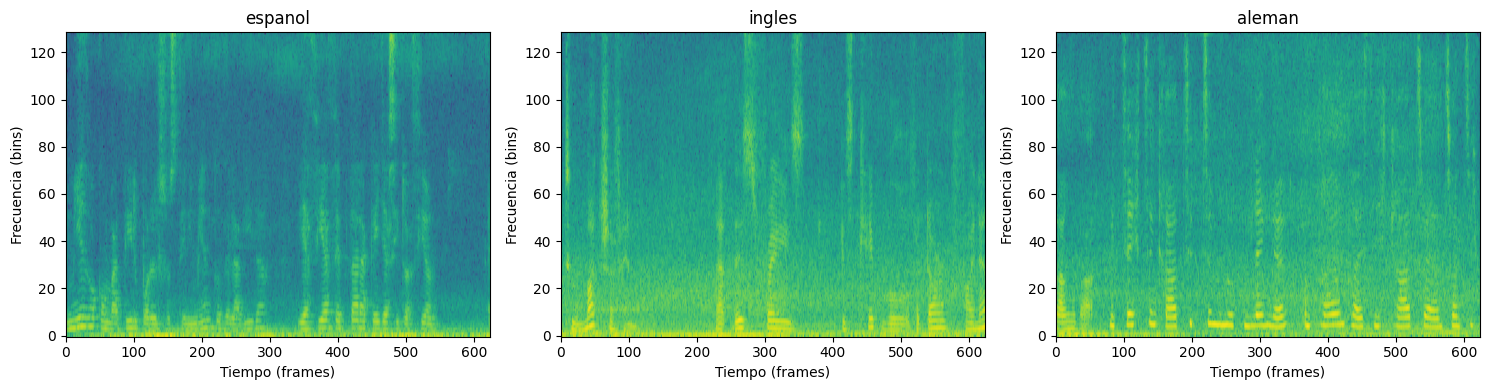

In [13]:
# ============================================================
# 3.c Mostrar espectrogramas de ejemplo (uno por clase)
# ============================================================

def plot_spectrogram(spectrogram, ax):
    spectrogram = tf.squeeze(spectrogram, axis=-1)  # [time, freq]
    spectrogram = spectrogram.numpy().T            # [freq, time] para ver mejor
    im = ax.imshow(
        spectrogram,
        aspect="auto",
        origin="lower"
    )
    ax.set_xlabel("Tiempo (frames)")
    ax.set_ylabel("Frecuencia (bins)")
    return im


import random

fig, axs = plt.subplots(1, len(CLASS_NAMES), figsize=(15, 4))

for i, class_name in enumerate(CLASS_NAMES):
    class_files = file_paths[labels == i]
    if len(class_files) == 0:
        axs[i].set_title(f"Sin audios para {class_name}")
        continue

    example_file = random.choice(class_files)
    audio = decode_audio(example_file)
    spec = get_spectrogram(audio)

    plot_spectrogram(spec, axs[i])
    axs[i].set_title(class_name)

plt.tight_layout()
plt.show()


In [14]:
# ============================================================
# 4. Definición y entrenamiento del modelo
# ============================================================

# Obtenemos la forma de entrada de un batch del dataset
for spectrograms_batch, labels_batch in train_ds.take(1):
    input_shape = spectrograms_batch.shape[1:]
    print("Forma de entrada del modelo:", input_shape)

# Modelo secuencial sencillo
model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=input_shape, name="input_spectrogram"),
        tf.keras.layers.Conv2D(16, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(len(CLASS_NAMES), activation="softmax", name="output"),
    ],
    name="sequential",   # importante: prefijo común para pesos en TF.js
)

model.summary()


Forma de entrada del modelo: (624, 129, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 622, 127, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 311, 63, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 309, 61, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 154, 30, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 147840)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     9,461,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,466,819 (36.11 MB)

 Trainable params: 9,466,819 (36.11 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# ============================================================
# 4.b Compilación y entrenamiento
# ============================================================

EPOCHS = 10  # puedes ajustar

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

#early_stop = tf.keras.callbacks.EarlyStopping(
#    monitor="val_loss",
#    patience=5,
#    restore_best_weights=True,
#)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
)


Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 31s 741ms/step - accuracy: 0.9811 - loss: 0.0830 - val_accuracy: 0.4500 - val_loss: 4.1975
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 35s 620ms/step - accuracy: 0.9888 - loss: 0.0611 - val_accuracy: 0.3500 - val_loss: 2.8423
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 645ms/step - accuracy: 0.9891 - loss: 0.0306 - val_accuracy: 0.3333 - val_loss: 3.8705
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 40s 615ms/step - accuracy: 1.0000 - loss: 0.0060 - val_accuracy: 0.3500 - val_loss: 3.6850
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 661ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.3333 - val_loss: 4.0338
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 610ms/step - accuracy: 0.9911 - loss: 0.0134 - val_accuracy: 0.4333 - val_loss: 4.0600
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 628ms/step - accuracy: 0.9981 - loss: 0.0025 - val_accuracy: 0.3833 - val_loss: 4.4199
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 616ms/step - accuracy: 0.9889 - loss: 0.0626 - val_accu

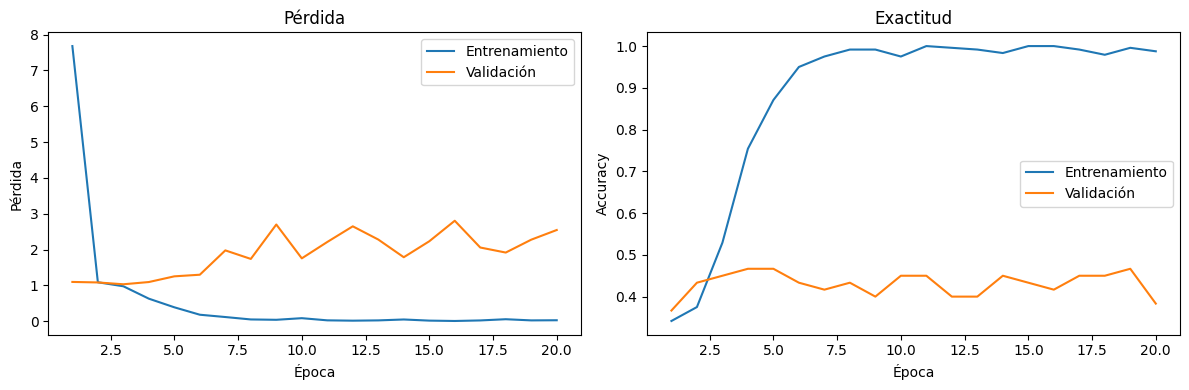

In [16]:
# ============================================================
# 4.c Gráficas de pérdida y accuracy
# ============================================================

history_dict = history.history
epochs_range = range(1, len(history_dict["loss"]) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_dict["loss"], label="Entrenamiento")
plt.plot(epochs_range, history_dict["val_loss"], label="Validación")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Pérdida")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_dict["accuracy"], label="Entrenamiento")
plt.plot(epochs_range, history_dict["val_accuracy"], label="Validación")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.title("Exactitud")
plt.legend()

plt.tight_layout()
plt.show()


In [17]:
# ============================================================
# 5. Pruebas rápidas del modelo en Python
# ============================================================

def predict_audio_file(file_path: str):
    """
    Preprocesa el audio, pasa por el modelo y muestra las probabilidades
    para cada idioma + predicción final.
    """
    audio = decode_audio(file_path)
    spec = get_spectrogram(audio)
    x = tf.expand_dims(spec, axis=0)  # [1, time, freq, 1]

    preds = model.predict(x, verbose=0)[0]

    print(f"\n🎧 Archivo: {file_path}")
    for class_name, prob in zip(CLASS_NAMES, preds):
        print(f"  {class_name:8s}: {prob*100:.2f}%")
    print("👉 Predicción final:", CLASS_NAMES[np.argmax(preds)])


# Probamos con el primer archivo de cada clase (si existe)
for i, class_name in enumerate(CLASS_NAMES):
    class_files = file_paths[labels == i]
    if len(class_files) == 0:
        print(f"\n(No hay audios para la clase {class_name})")
        continue

    example_file = class_files[0]
    predict_audio_file(example_file)



🎧 Archivo: /content/dataset_idiomas/espanol/espanol_0000.wav
  espanol : 99.11%
  ingles  : 0.83%
  aleman  : 0.06%
👉 Predicción final: espanol

🎧 Archivo: /content/dataset_idiomas/ingles/ingles_0000.wav
  espanol : 0.01%
  ingles  : 99.87%
  aleman  : 0.11%
👉 Predicción final: ingles

🎧 Archivo: /content/dataset_idiomas/aleman/aleman_0000.wav
  espanol : 0.01%
  ingles  : 0.01%
  aleman  : 99.99%
👉 Predicción final: aleman


In [18]:
# ============================================================
# 6. Exportar a TensorFlow.js
# ============================================================

MODEL_KERAS_PATH = "/content/model_audio_idiomas.keras"
model.save(MODEL_KERAS_PATH)
print("Modelo Keras guardado en:", MODEL_KERAS_PATH)


Modelo Keras guardado en: /content/model_audio_idiomas.keras


In [19]:
# ============================================================
# 6.b Convertir modelo Keras -> carpeta TF.js
# ============================================================

TFJS_TARGET_DIR = "/content/model_audio_idiomas_tfjs"
tfjs.converters.save_keras_model(model, TFJS_TARGET_DIR)

print("Carpeta TF.js creada en:", TFJS_TARGET_DIR)
print("Contenido:")
print(os.listdir(TFJS_TARGET_DIR))


failed to lookup keras version from the file,
    this is likely a weight only file
Carpeta TF.js creada en: /content/model_audio_idiomas_tfjs
Contenido:
['group1-shard10of10.bin', 'model.json', 'group1-shard5of10.bin', 'group1-shard2of10.bin', 'group1-shard7of10.bin', 'group1-shard4of10.bin', 'group1-shard1of10.bin', 'group1-shard6of10.bin', 'group1-shard9of10.bin', 'group1-shard8of10.bin', 'group1-shard3of10.bin']


In [20]:
# ============================================================
# 7. Parcheo de model.json (InputLayer + nombres de pesos)
# ============================================================

import json
from pathlib import Path

def patch_input_layers(model_json_path: str) -> None:
    """
    Arregla el problema:
      An InputLayer should be passed either a `batchInputShape` or an `inputShape`.

    Copia batch_shape -> batchInputShape si no existe.
    """
    path = Path(model_json_path)
    data = json.loads(path.read_text(encoding="utf-8"))

    topo = data.get("modelTopology") or data.get("model_topology")
    if topo is None:
        print(f"⚠️ No encontré modelTopology en {path}")
        return

    config = topo.get("model_config", {}).get("config", {})
    layers = config.get("layers") or config.get("layer") or []

    changed = False
    for layer in layers:
        if layer.get("class_name") == "InputLayer":
            cfg = layer.get("config", {})
            if "batch_shape" in cfg and "batchInputShape" not in cfg:
                cfg["batchInputShape"] = cfg["batch_shape"]
                changed = True
                print(f"✅ Añadido batchInputShape en InputLayer de {path.name}")

    if changed:
        backup = path.with_suffix(".backup_input.json")
        backup.write_text(json.dumps(data, indent=2), encoding="utf-8")
        path.write_text(json.dumps(data, separators=(",", ":")), encoding="utf-8")
        print(f"💾 Guardado {path} (copia de seguridad: {backup.name})")
    else:
        print(f"ℹ️ No hubo nada que parchear en InputLayer de {path.name}")


def fix_weight_prefix(model_json_path: str, prefix: str) -> None:
    """
    Arregla nombres de pesos del estilo:
      sequential/conv2d_1/kernel  -> conv2d_1/kernel
    """
    path = Path(model_json_path)
    data = json.loads(path.read_text(encoding="utf-8"))

    manifest = data.get("weightsManifest") or data.get("weights_manifest")
    if manifest is None:
        print(f"⚠️ No encontré weightsManifest en {path}")
        return

    changed = False
    for group in manifest:
        for w in group.get("weights", []):
            name = w.get("name", "")
            if name.startswith(prefix + "/"):
                new_name = name.split("/", 1)[1]
                print(f"{name}  ->  {new_name}")
                w["name"] = new_name
                changed = True

    if changed:
        backup = path.with_suffix(".backup_names.json")
        backup.write_text(json.dumps(data, indent=2), encoding="utf-8")
        path.write_text(json.dumps(data, separators=(",", ":")), encoding="utf-8")
        print(f"✅ Parcheado {path} (copia de seguridad: {backup.name})")
    else:
        print(f"ℹ️ No encontré pesos con prefijo '{prefix}' en {path.name}")


def quick_fix_tfjs_model(model_json_path: str, prefixes=None):
    """
    Helper general:
      1) Parchea InputLayer (batch_shape -> batchInputShape).
      2) Opcionalmente quita prefijos de nombres de pesos.
    """
    if prefixes is None:
        prefixes = []

    print(f"\n🔧 Arreglando modelo TF.js: {model_json_path}\n")
    patch_input_layers(model_json_path)
    for p in prefixes:
        fix_weight_prefix(model_json_path, p)
    print("\n✅ quick_fix_tfjs_model terminado\n")


In [21]:
# ============================================================
# 7.b Aplicar quick_fix_tfjs_model sobre model.json
# ============================================================

model_json_path = Path(TFJS_TARGET_DIR) / "model.json"
print("Ruta del model.json:", model_json_path)

# El modelo se llama "sequential", así que es típico el prefijo "sequential/"
quick_fix_tfjs_model(str(model_json_path), prefixes=["sequential"])


Ruta del model.json: /content/model_audio_idiomas_tfjs/model.json

🔧 Arreglando modelo TF.js: /content/model_audio_idiomas_tfjs/model.json

✅ Añadido batchInputShape en InputLayer de model.json
💾 Guardado /content/model_audio_idiomas_tfjs/model.json (copia de seguridad: model.backup_input.json)
sequential/conv2d/kernel  ->  conv2d/kernel
sequential/conv2d/bias  ->  conv2d/bias
sequential/conv2d_1/kernel  ->  conv2d_1/kernel
sequential/conv2d_1/bias  ->  conv2d_1/bias
sequential/dense/kernel  ->  dense/kernel
sequential/dense/bias  ->  dense/bias
sequential/output/kernel  ->  output/kernel
sequential/output/bias  ->  output/bias
✅ Parcheado /content/model_audio_idiomas_tfjs/model.json (copia de seguridad: model.backup_names.json)

✅ quick_fix_tfjs_model terminado



In [26]:
# ============================================================
# 8. Info para integración web
# ============================================================

print("📁 Carpeta a descargar y subir a tu página web:")
print("   ->", TFJS_TARGET_DIR)

print("\n📄 Archivos dentro de esa carpeta (mínimo model.json + group1-shard*.bin):")
for fname in os.listdir(TFJS_TARGET_DIR):
    print("  -", fname)

labels = ["espanol", "ingles", "frances"]
print("\nArreglo de etiquetas en el orden correcto:")
print(labels)

print("\nEn tu JavaScript puedes usar:")
print('const LABELS_AUD = ["espanol", "ingles", "frances"];')


📁 Carpeta a descargar y subir a tu página web:
   -> /content/model_audio_idiomas_tfjs

📄 Archivos dentro de esa carpeta (mínimo model.json + group1-shard*.bin):
  - model.backup_input.json
  - group1-shard10of10.bin
  - model.json
  - group1-shard5of10.bin
  - group1-shard2of10.bin
  - group1-shard7of10.bin
  - group1-shard4of10.bin
  - group1-shard1of10.bin
  - group1-shard6of10.bin
  - group1-shard9of10.bin
  - group1-shard8of10.bin
  - model.backup_names.json
  - group1-shard3of10.bin

Arreglo de etiquetas en el orden correcto:
['espanol', 'ingles', 'frances']

En tu JavaScript puedes usar:
const LABELS_AUD = ["espanol", "ingles", "frances"];


In [23]:
# ============================================================
# 9.a Crear ZIP del dataset de audio usado
# ============================================================

import shutil

zip_base_path = "/content/dataset_idiomas_audio"
zip_file = shutil.make_archive(zip_base_path, "zip", BASE_DIR)

print("ZIP creado con el dataset de audio:")
print(" ->", zip_file)


ZIP creado con el dataset de audio:
 -> /content/dataset_idiomas_audio.zip


In [24]:
# ============================================================
# 9.b Descargar el ZIP a tu PC
# ============================================================

from google.colab import files

files.download(zip_file)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>